In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [5]:
# Importing required packages 
import pandas as pd
import matplotlib.pyplot as plt #(plotin histograms in cell #3)
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from bayesian import *
from BAMT.bayesian.train_bn import structure_learning, parameter_learning
from BAMT.preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from BAMT.bayesian.save_bn import save_structure, save_params, read_structure, read_params
from BAMT.bayesian.sampling import generate_synthetics
from BAMT.external.libpgm.hybayesiannetwork import HyBayesianNetwork
from BAMT.visualization.visualization import draw_BN
from BAMT.bayesian.calculate_accuracy import calculate_acc
from functools import partial
from scipy.stats.distributions import norm

In [3]:
# Defining some constants 
nbins=30

## Step 01: Choose variables for sampling from dataset 
overall – 10 variables : 'T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out'

3– target variables : 'T6','T2','T_out'

the rest - predictors : 'T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out'

In [4]:
# Reading Data 
energydata = pd.read_csv("./energydata_complete.csv")
# Creating subsamples    
# Choosing 10 continous colomns, 'T6','T2','T_out' are the target variables
sample_energydata=energydata[[ 'T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out']] 
df_sample_colomn_energydata = pd.DataFrame(sample_energydata)
train, test = train_test_split(df_sample_colomn_energydata, test_size=0.2, random_state=42)

## Step 02 : Sampling of chosen target variables : T2, T_out and T6

### 1. Inverse transform sampling

In [18]:
def Inverse_Sampling(dist_fun, column, column_name, num):
    dist_par = dist_fun.fit(column)
    rand = np.random.uniform(size=num)
    sampled = dist_fun(*dist_par)
    sampled_app= sampled.ppf(rand) # ppf returns Inverse cumulative density function (ICDF)
    plt.figure()
    sns.distplot(column, kde=True)
    sns.distplot(sampled_app,kde=True, norm_hist=True)
    plt.title('Inverse Transform Sampling for '+ column_name)
    plt.legend(['Original Data', 'Sampled Data'])

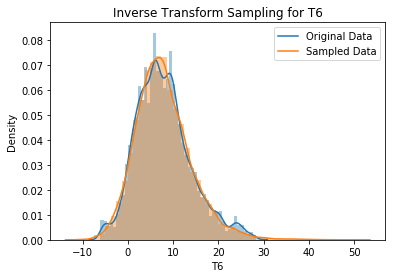

In [71]:
Inverse_Sampling(stats.exponnorm, df_sample_colomn_energydata['T6'], "T6", len(df_sample_colomn_energydata['T6']))

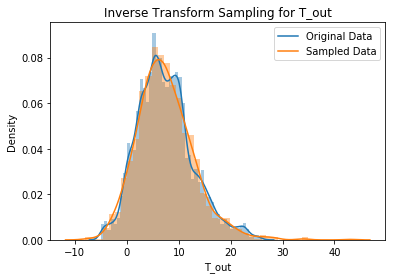

In [72]:
Inverse_Sampling(stats.exponnorm, df_sample_colomn_energydata['T_out'], 'T_out', 1500)

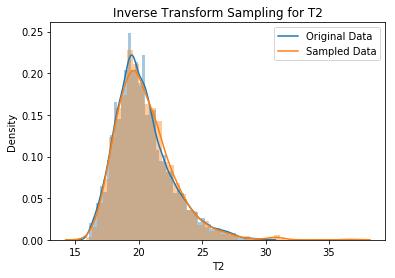

In [73]:
Inverse_Sampling(stats.lognorm, df_sample_colomn_energydata['T2'], 'T2', 1500)

### 2. Accept-Reject Sampling

In [34]:
def accept_reject_sampling (data, distribution,col_name):
    # plotting the original data
    plt.figure(figsize=(8,8))
    min_value, max_value = data.min(), data.max()
    x = np.linspace(min_value, max_value, len(data))
    data.hist(density=True,stacked=True,bins=20, label='Original Data')
    # fitting the data to the corresponding distribution function
    MLE_params = distribution.fit(data)
    values = distribution.pdf(x,*MLE_params)
    plt.plot(x,values,label=distribution.__class__.__name__)
    # generating samples
    N = 1000000
    S = 10
    samples = np.random.normal(data.mean(), data.std(), size=(N,))
    # calculating the acceptance ration
    accept = distribution.pdf(samples,*MLE_params) / (S*norm.pdf(samples,data.mean(), data.std()) + 1e-3)
    # choose only the accepted samples
    mask = np.random.random(size=(N,)) < accept
    samples = samples[mask]
    # plotting the samppled data
    plt.hist(samples, bins=20, density=True,alpha=0.4, color='orange', label='Sampled Data')
    plt.title(col_name)
    plt.legend()

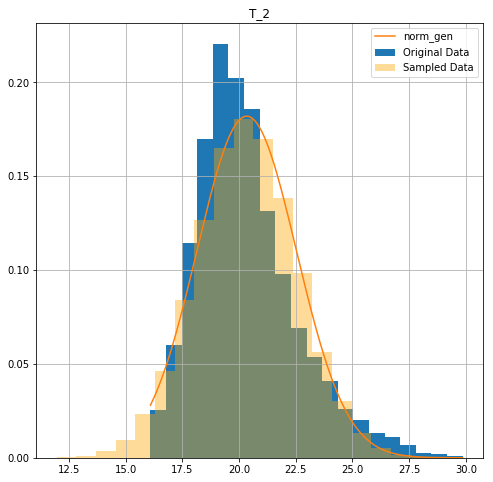

In [35]:
accept_reject_sampling (df_sample_colomn_energydata['T2'], norm,'T_2')

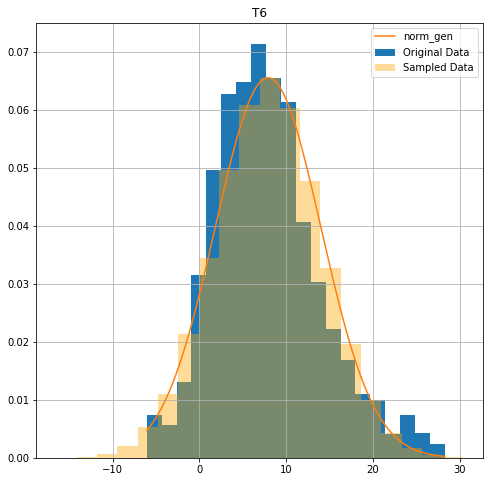

In [30]:
accept_reject_sampling (df_sample_colomn_energydata['T6'], norm,'T6')

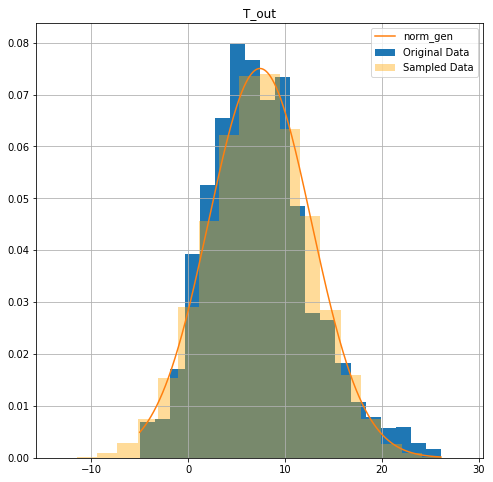

In [31]:
accept_reject_sampling (df_sample_colomn_energydata['T_out'], norm,'T_out')

## Step 03 relations between predictors and chosen target 

In [275]:
df_sample_colomn_energydata.corr()

,T1,T4,T5,RH_3,RH_7,RH_9,RH_out,T6,RH_2,T2,T_out
T1,1.000000,0.877001,0.885247,-0.028550,0.135182,0.071756,-0.345481,0.654769,-0.002509,0.836834,0.682854
T4,0.877001,1.000000,0.871813,-0.140457,0.043527,-0.025549,-0.388602,0.652350,-0.047304,0.762066,0.663479
T5,0.885247,0.871813,1.000000,-0.050062,0.148905,0.072308,-0.273953,0.629161,0.110409,0.720550,0.651335
RH_3,-0.028550,-0.140457,-0.050062,1.000000,0.832685,0.833538,0.356192,0.076833,0.678326,0.121497,0.118237
RH_7,0.135182,0.043527,0.148905,0.832685,1.000000,0.858686,0.378519,0.256077,0.690584,0.229212,0.294222
RH_9,0.071756,-0.025549,0.072308,0.833538,0.858686,1.000000,0.359377,0.184424,0.676467,0.157346,0.223282
RH_out,-0.345481,-0.388602,-0.273953,0.356192,0.378519,0.359377,1.000000,-0.569119,0.584911,-0.505291,-0.574186
T6,0.654769,0.652350,0.629161,0.076833,0.256077,0.184424,-0.569119,1.000000,-0.009670,0.801186,0.974778
RH_2,-0.002509,-0.047304,0.110409,0.678326,0.690584,0.676467,0.584911,-0.009670,1.000000,-0.165610,0.033703
T2,0.836834,0.762066,0.720550,0.121497,0.229212,0.157346,-0.505291,0.801186,-0.165610,1.000000,0.792247


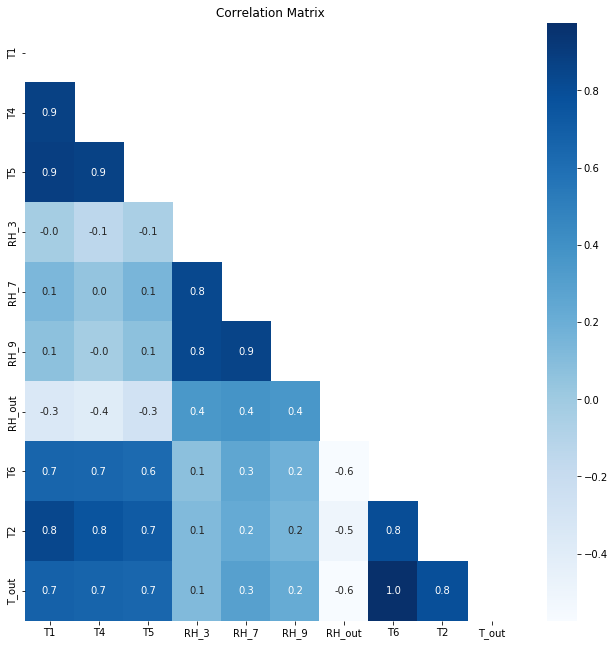

In [75]:
#Pair correlation coefficients, Correlation Matrix
fig, ax = plt.subplots(figsize=(11,11))
corr = df_sample_colomn_energydata[df_sample_colomn_energydata.columns[0:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()

## Step 04 Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm

In [44]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

In [45]:
# Targets T6,T_out,T2
names=['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out']
bayes_manual = dict(
    {'V': ['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out'],
     'E': [   
        ['T1', 'T6'],
        ['T5', 'T6'],
        ['T4', 'T6'],

        ['T1', 'T2'],
        ['T4', 'T2'],
        ['T5', 'T2'],
    
        ['T1', 'T_out'],
        ['T4', 'T_out'],
        ['T5', "T_out"],
    ]
    }
)

In [47]:
# Getting nodes' type an signs
nodes_type = get_nodes_type(train)
nodes_sign = get_nodes_sign(train)

In [48]:
print("Obtained network structure", bayes_manual)

Obtained network structure {'V': ['T1', 'T4', 'T5', 'RH_3', 'RH_7', 'RH_9', 'RH_out', 'T6', 'T2', 'T_out'], 'E': [['T1', 'T6'], ['T5', 'T6'], ['T4', 'T6'], ['T1', 'T2'], ['T4', 'T2'], ['T5', 'T2'], ['T1', 'T_out'], ['T4', 'T_out'], ['T5', 'T_out']]}


In [49]:
draw_BN(bayes_manual, nodes_type, 's&p_bayes_manual')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

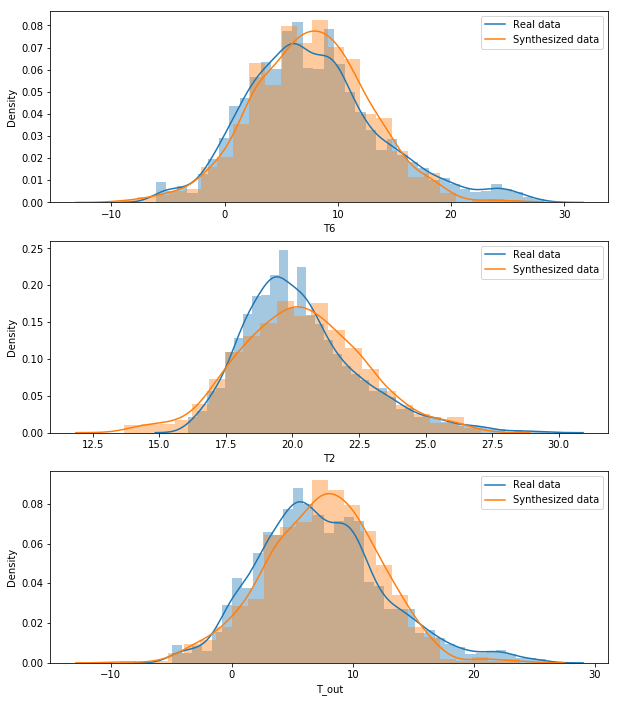

In [52]:
#Finding and applying the model for the three targets.
params = parameter_learning(train, nodes_type, bayes_manual, 'simple')
save_structure(bayes_manual, 's&p_bayes_manual_structure')
skel = read_structure('s&p_bayes_manual_structure')
save_params(params, 's&p_bayes_manual_params')
params = read_params('s&p_bayes_manual_params')
bayes_manual = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_manual, nodes_sign, 'simple', 800)

fix, ax = plt.subplots(3, 1, figsize=(10, 12))


sns.distplot(test['T6'], ax=ax[0])
sns.distplot(synth_df['T6'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['T2'], ax=ax[1])
sns.distplot(synth_df['T2'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['T_out'], ax=ax[2])
sns.distplot(synth_df['T_out'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_manual, df_sample_colomn_energydata, ['T2', 'T6', 'T_out'], 'simple')[0:2])

## Step 05 Building a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

### 1.Search strategy Hill-Climbing with K2 score function

In [54]:
# 1. Find the structure of the model
# structural models can not deal with continous data that is why we discretize the continous data
discrete_data, kbins = discretization(df_sample_colomn_energydata, 'equal_frequency', ['T1', 'T4', 'T5', 'RH_3','RH_7','RH_9', 'RH_out','T6','T2','T_out'])
# structure learning, we need discrete data
bayes_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print("Obtained network structure", bayes_hc)
draw_BN(bayes_hc, nodes_type, 's&p_bayes_hc')

# 2. Launch parameter learning, we use raw data
params = parameter_learning(train, nodes_type, bayes_hc, 'simple')
save_structure(bayes_hc, 's&p_bayes_hc_structure')
skel = read_structure('s&p_bayes_hc_structure')
save_params(params, 'p_bayes_hc_params')
params = read_params('p_bayes_hc_params')
# create Hy Bayesian Network with the structure and parameters
bayes_hc = HyBayesianNetwork(skel, params)
# generate synths from this data
synth_df = generate_synthetics(bayes_hc, nodes_sign, 'simple', 800)

Obtained network structure {'V': ['T1', 'T4', 'T5', 'RH_3', 'RH_7', 'RH_9', 'RH_out', 'T6', 'T2', 'T_out'], 'E': [['T1', 'T4'], ['T1', 'T2'], ['T1', 'RH_3'], ['T4', 'T_out'], ['T4', 'T2'], ['T4', 'RH_out'], ['T4', 'RH_3'], ['T5', 'T1'], ['T5', 'T4'], ['T5', 'RH_3'], ['T5', 'T_out'], ['T5', 'RH_out'], ['T5', 'T2'], ['RH_3', 'T2'], ['RH_3', 'T_out'], ['RH_3', 'RH_out'], ['RH_7', 'RH_out'], ['RH_7', 'RH_3'], ['RH_7', 'T_out'], ['RH_7', 'T4'], ['RH_7', 'T5'], ['RH_7', 'T1'], ['RH_7', 'T2'], ['RH_9', 'RH_7'], ['RH_9', 'RH_3'], ['RH_9', 'T5'], ['RH_9', 'T1'], ['RH_9', 'T2'], ['RH_9', 'T4'], ['RH_9', 'T_out'], ['RH_9', 'T6'], ['T2', 'T_out'], ['T2', 'RH_out'], ['T2', 'T6'], ['T_out', 'T6'], ['T_out', 'RH_out']]}


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

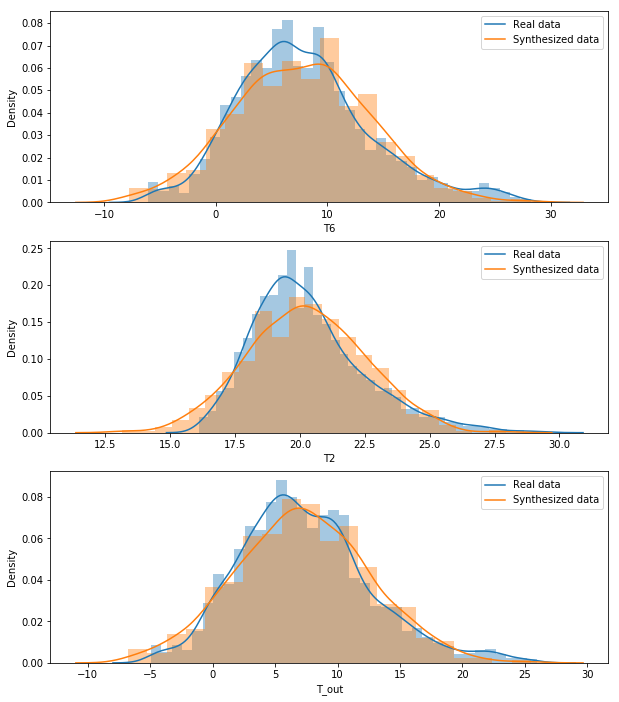

In [55]:
fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(test['T6'], ax=ax[0])
sns.distplot(synth_df['T6'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['T2'], ax=ax[1])
sns.distplot(synth_df['T2'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['T_out'], ax=ax[2])
sns.distplot(synth_df['T_out'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_hc, test, [
      'T6', 'T2', 'T_out'], 'simple')[0:2])

### 2.Search strategy PC algorithms with MI score function

In [69]:
bayes_second= structure_learning(discrete_data, 'PC', nodes_type, 'MI')
print("Obtained network structure", bayes_second)
draw_BN(bayes_second, nodes_type, 's&p_bayes_second')



Working for n conditional variables: 5: 100%|██████████| 5/5 [3:59:35<00:00, 2875.09s/it]


Obtained network structure {'V': ['T1', 'T4', 'T5', 'RH_3', 'RH_7', 'RH_9', 'RH_out', 'T6', 'T2', 'T_out'], 'E': [['RH_7', 'T1'], ['T5', 'T1'], ['T5', 'RH_7'], ['T2', 'T1'], ['T2', 'RH_7'], ['T2', 'T5'], ['RH_out', 'T1'], ['RH_out', 'RH_7'], ['RH_out', 'T5'], ['RH_out', 'T2'], ['T6', 'T1'], ['T6', 'RH_7'], ['T6', 'T5'], ['T6', 'T2'], ['T6', 'RH_out'], ['T6', 'T4'], ['RH_9', 'T1'], ['RH_9', 'RH_7'], ['RH_9', 'T5'], ['RH_9', 'T2'], ['RH_9', 'RH_out'], ['RH_9', 'T4'], ['RH_9', 'T6'], ['T4', 'T1'], ['T4', 'RH_7'], ['T4', 'T5'], ['T4', 'T2'], ['T4', 'RH_out'], ['RH_3', 'T1'], ['RH_3', 'RH_7'], ['RH_3', 'T5'], ['RH_3', 'T2'], ['RH_3', 'RH_out'], ['RH_3', 'T4'], ['RH_3', 'T6'], ['RH_3', 'RH_9'], ['T_out', 'T1'], ['T_out', 'RH_7'], ['T_out', 'T5'], ['T_out', 'T2'], ['T_out', 'RH_out'], ['T_out', 'T4'], ['T_out', 'T6'], ['T_out', 'RH_9'], ['T_out', 'RH_3']]}


In [70]:
# 2. Launch parameter learning, we use raw data
params_second = parameter_learning(train, nodes_type, bayes_second, 'simple')
save_structure(bayes_second, 's&p_bayes_evo_structure')
skel_second = read_structure('s&p_bayes_evo_structure')

In [72]:
save_params(params_second, 'bayes_second')
params_second = read_params('bayes_second')
# create Hy Bayesian Network with the structure and parameters
bayes_second = HyBayesianNetwork(skel_second, params_second)
# generate synths from this data
synth_second = generate_synthetics(bayes_second, nodes_sign, 'simple', 800)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Working for n conditional variables: 5: 100%|██████████| 5/5 [8:15:27<00:00, 5945.59s/it]

941


942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
115

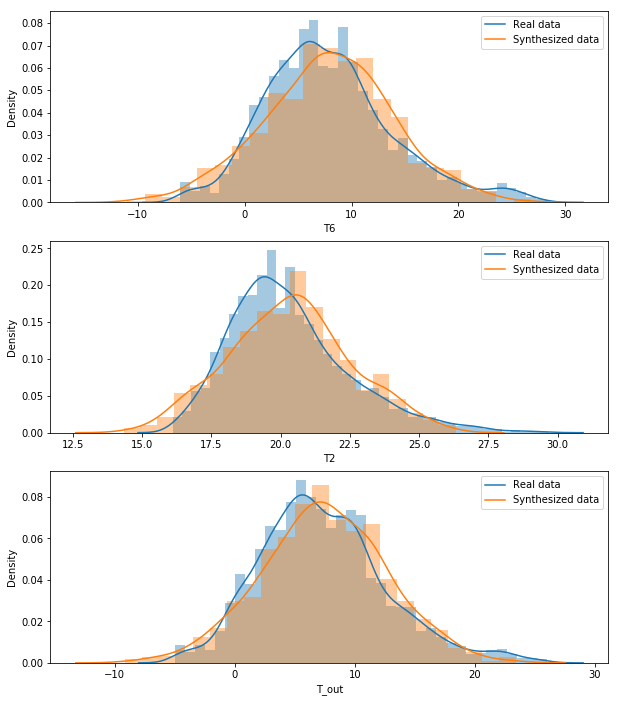

In [73]:
fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(test['T6'], ax=ax[0])
sns.distplot(synth_second['T6'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['T2'], ax=ax[1])
sns.distplot(synth_second['T2'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['T_out'], ax=ax[2])
sns.distplot(synth_second['T_out'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_second, test, [
      'T6', 'T2', 'T_out'], 'simple')[0:2])